In [5]:
Needs["Screws`", "./Screws.m"];
Needs["RobotLinks`", "./RobotLinks.m"];

In [51]:
(* base pose of link i frame in the snake head frame (all joint angles = 0) *)
gsi0[i_] := TwistExp[{0, l(i - 1), 0, 0, 0, 0}, 1];

(* twist coordinates for joint i *)
ξ[i_] := Piecewise[{{{0, 0, -l(i - 1/2), 1, 0, 0}, EvenQ[i]},
              {{l(i - 1/2), 0, 0, 0, 0, 1}, OddQ[i]}}];

n = 4; 
ids = Range[n];
gsi0s = Map[gsi0, ids];
ξs = Map[ξ, ids];

(* create vector of angles which are all functions of t *)
θs = Through[Array[Indexed[θ, #] &, n][t]];

(* product of exponentials FK for link i *)
gs[i_] := Dot @@ Append[MapThread[TwistExp, {ξs[[;; i-1]], θs[[;; i-1]]}], gsi0s[[i]]] // Simplify;

2
 l (Sin[θ [t]] (θ )'[t]  - Cos[θ [t]] (θ )''[t])
         1       1              1       1
{-----------------------------------------------, 
                        2
 
      1                         2
>   -(-) (l (Cos[θ [t]] (θ )'[t]  + Sin[θ [t]] (θ )''[t])), 0}
      2           1       1              1       1
                      2
 l Sin[θ [t]] (θ )'[t]
        1       1          1                        2
{----------------------, -(-) (l Cos[θ [t]] (θ )'[t] ), 0}
           2               2          1       1
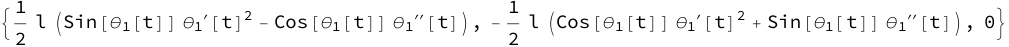
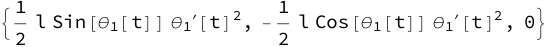

In [69]:
(* differentiate position twice wrt time to get acceleration *)
p[i_] := gs[i][[;; 3, -1]];
v[i_] := D[p[i], t];
a[i_] := D[p[i], {t, 2}];

(* set all joint accelerations to zero since we are assuming constant joint velocity *)
acv[i_] := a[i] /. Thread[D[θs, {t, 2}] -> 0];

a[2] // Simplify
acv[2] // Simplify

0


0

(θ )'[t]
  1
            -(θ )'[t]
0              1        0

(θ )'[t]
  1         0           0


0           0           0
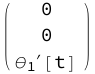
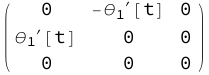

In [105]:
(* differentiate rotation matrix to get angular velocity *)
R[i_] := gs[i][[1 ;; 3, 1 ;; 3]];
ωhat[i_] := D[R[i], t].Transpose[R[i]];
ω[i_] := UnSkew[ωhat[i]];

ω[2] // Simplify // MatrixForm
ωhat[2] // Simplify // MatrixForm


In [ ]:
ak = {ax, ay, az};
qk = {qx, qy, qz, qw};
ωk = {ωx, ωy, ωz};
xk = Join[ak, qk, ωk];

(* rotation matrix from virtual chassis frame to snake head frame *)
Ck = {{C11, C12, C13}, {C21, C22, C23}, {C31, C32, C33}};

qtoR[{x, y, z, w}] := {{w^2 + x^2 - y^2 - z^2, 2(xy - zw), 2(xz + yw)},
                       {2(xy + zw), w^2 - x^2 + y^2 - z^2, 2(yz - xw)},
                       {2(xz - yw), 2(yz + xw), w^2 - x^2 - y^2 + z^2}};
Rk = qtoR[qk];
g = {0, 0, -9.81};

(* predicted acceleration measurement at link i *)
αhat[i_] := Transpose[Ck].gs[i].Rk.(g + ak) + acv[i]

In [ ]:
(* Scratch Work *)

(* angles = {0, π/2, 0, 0};
gs[3] // Simplify // MatrixForm;
gs[3] /. Thread[θs -> angles] // Simplify // MatrixForm; *)
(* p[3] // Simplify *)
(* v[2] // Simplify *)

(* gs1 = gsi0s[[1]] // MatrixForm
gs2 = TwistExp[ξ[1], θs[[1]]].gsi0s[[2]] // Simplify // MatrixForm
gs3 = TwistExp[ξ[1], θs[[1]]].TwistExp[ξ[2], θs[[2]]].gsi0s[[3]] // Simplify // MatrixForm *)